# K-Min-Sum-Radii LP proof of concept

The goal is to find the optimal solution to a linear program that calculates a k-msr solution to a given selection of points and an integer k. Gurobi is used to calculate the solution within the necessary constraints. This notebook is supposed to be an exercise to find these specific constraints and to improve my grasp on the problem itself, before proceeding with implementing an algorithm of my own.

In [1]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import DistanceMetric
from scipy.spatial import distance as dist

We need data points to perform the clustering on. An easy stand-in for actual data are sklearn blobs, that form very obvious clusters and are verifiable by hand if they are small enough.

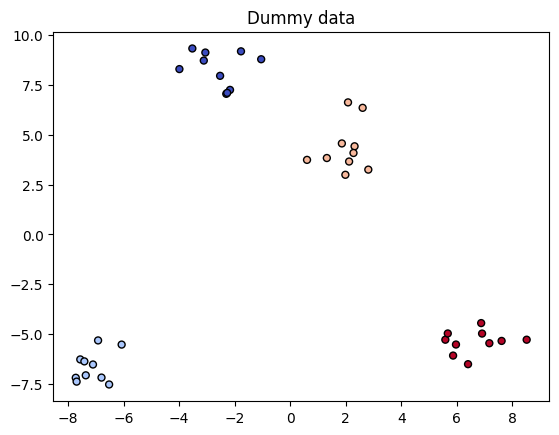

In [2]:
# generate dummy data for k centers
k = 4
points, cluster_membership = make_blobs(
    n_samples=40,
    n_features=4,
    centers=4,
    random_state=42
)

plt.title("Dummy data")
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=25, edgecolor="k", cmap="coolwarm")
plt.show()

In [3]:
points

array([[  2.08253044,   6.62469367,  -9.78067108,   9.69974439],
       [ -3.52202874,   9.32853346,   3.73185476,   0.56086598],
       [ -7.55654919,  -6.2684333 ,  -7.80732823,   8.25480303],
       [  2.31842051,   4.42250683,  -9.58319666,   9.16360991],
       [ -2.16557933,   7.25124597,   4.96396281,   1.5880874 ],
       [  6.87631275,  -4.44607503,  -7.97098389,  -6.14727594],
       [  7.17079438,  -5.45623311,  -6.11300781,  -5.98546159],
       [ -2.30033403,   7.054616  ,   3.31169279,   2.17003092],
       [  2.27985063,   4.08700564, -11.50708133,   9.37168317],
       [ -7.40938739,  -6.36684216,  -8.74125021,   8.29216791],
       [ -7.09929908,  -6.52299702,  -7.36043371,   6.8052527 ],
       [  5.96882809,  -5.52096409,  -6.07042818,  -7.04626122],
       [  2.60915733,   6.35190718, -10.57884644,   8.83189931],
       [ -7.35880143,  -7.06576857,  -9.94466273,   6.12731629],
       [  7.61222895,  -5.34043686,  -5.5414405 ,  -4.43511682],
       [  5.5865491 ,  -5

In [4]:
# distance function
distances = DistanceMetric.get_metric('euclidean')

# we need all distances as possible radii
radii = distances.pairwise(points)
radii


array([[ 0.        , 17.45936099, 16.28270607, ..., 17.0434731 ,
        21.93938801, 21.26466624],
       [17.45936099,  0.        , 21.2577548 , ...,  2.22487818,
        23.0079931 , 20.6947022 ],
       [16.28270607, 21.2577548 ,  0.        , ..., 21.62647192,
        20.79624633, 20.51605172],
       ...,
       [17.0434731 ,  2.22487818, 21.62647192, ...,  0.        ,
        23.01233527, 20.69372686],
       [21.93938801, 23.0079931 , 20.79624633, ..., 23.01233527,
         0.        ,  2.66472814],
       [21.26466624, 20.6947022 , 20.51605172, ..., 20.69372686,
         2.66472814,  0.        ]], shape=(40, 40))

## Defining the ILP

In [5]:
# model
m = gp.Model("k_msr")

# variable
y = m.addVars(len(points), len(points), vtype=GRB.BINARY, name="Y") # for dummies (me): adds a 10x10 grid of binary variables y_ij that can be either 0 or 1, which will be used to check which clusters overlap a given point

Set parameter Username
Set parameter LicenseID to value 2629995
Academic license - for non-commercial use only - expires 2026-03-01


In [6]:
# objective:
m.setObjective(gp.quicksum([y[i, j] * radii[i][j] for i in range(len(radii)) for j in range(len(radii[i]))]),  GRB.MINIMIZE) # should be the minimization of the sum of active y_ij times their respective radii

In [7]:
# constraints:

# every point is covered by atleast one center/radius y_ij
for n in range(len(points)):
        m.addConstr(gp.quicksum([y[i, j] for j in range(len(radii)) for i in range (len(radii)) if radii[i][j] >= dist.euclidean(points[n], points[i])]) >= 1, "every_point_covered") 
"""for every point we enforce that the sum of all y_ij that represent a center/radius combination where the distance from the point to that center is 
    close enough to the point for the radius to cover it is atleast 1. because then, there is always a y_ij active for every point that covers it"""

# exactly k centers open in total (not per row of y, so we don't get the sum of 10 different solutions)
m.addConstr(gp.quicksum([y[i, j] for i in range (len(radii)) for j in range(len(radii[i]))]) == k, "select_k_centers")

<gurobi.Constr *Awaiting Model Update*>

In [8]:
# do the thing
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 5800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 41 rows, 1600 columns and 34400 nonzeros
Model fingerprint: 0xcde25352
Variable types: 0 continuous, 1600 integer (1600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 74.5787284
Presolve added 153 rows and 0 columns
Presolve removed 0 rows and 274 columns
Presolve time: 0.02s
Presolved: 194 rows, 1326 columns, 17187 nonzeros
Variable types: 0 continuous, 1326 integer (1158 binary)

Root relaxation: objective 1.049930e+01, 263 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntI

In [9]:
m.display()

Minimize
17.459360994784006 Y[0,1] + 16.282706066945806 Y[0,2] + 2.2872925756321396 Y[0,3]
+ 17.367849949276998 Y[0,4] + 19.99863219011038 Y[0,5] + 20.768164634457012 Y[0,6]
+ 15.732161665952306 Y[0,7] + 3.09304256326695 Y[0,8] + 16.184504155366565 Y[0,9]
+ 16.47432532563343 Y[0,10] + 21.37322900059148 Y[0,11] + 1.3198436713752821 Y[0,12]
+ 17.010486165909708 Y[0,13] + 19.78654318723107 Y[0,14] + 19.23408178450396 Y[0,15]
+ 16.703194618585197 Y[0,16] + 2.9369739982679306 Y[0,17] + 18.313662754273498 Y[0,18]
+ 14.718894018297812 Y[0,19] + 17.043413725706323 Y[0,20] + 3.4256736377407844 Y[0,21]
+ 17.01248990635247 Y[0,22] + 17.552936801487345 Y[0,23] + 16.20952568695135 Y[0,24]
+ 17.300078329668622 Y[0,25] + 15.124837381449419 Y[0,26] + 16.025905320601275 Y[0,27]
+ 22.169668201499494 Y[0,28] + 16.631042735526293 Y[0,29] + 4.165907807102398 Y[0,30]
+ 15.780736575569618 Y[0,31] + 3.2714271563906427 Y[0,32] + 3.3949324363124633 Y[0,33]
+ 21.531619400060592 Y[0,34] + 20.601629970912416 Y[0,3

C:\Users\Mattis\AppData\Local\Temp\ipykernel_15112\137993151.py:1: DeprecationWarning: Model.display() is deprecated
  m.display()


+ 17.484405224016367 Y[36,15] + 16.549556822362433 Y[36,16]
+ 1.8372329375249397 Y[36,17] + 18.07569343671529 Y[36,18] + 11.872275415904992 Y[36,19]
+ 14.188732711735872 Y[36,20] + 2.6623604122819784 Y[36,21]
+ 14.276752300932491 Y[36,22] + 17.549068065548106 Y[36,23] + 16.31897936331652 Y[36,24]
+ 14.414050907266022 Y[36,25] + 12.703759554005348 Y[36,26]
+ 15.958005002638496 Y[36,27] + 20.479244843852523 Y[36,28]
+ 13.588034151822109 Y[36,29] + 2.3356916322538908 Y[36,30]
+ 15.505332591007214 Y[36,31] + 2.8604912959407285 Y[36,32] + 2.901185103204503 Y[36,33]
+ 20.131781717613418 Y[36,34] + 19.03339624947637 Y[36,35] + 17.104616076576868 Y[36,37]
+ 20.257897106560236 Y[36,38] + 19.66775676868596 Y[36,39] + 17.04347309621153 Y[37,0]
+ 2.224878178423274 Y[37,1] + 21.62647192388426 Y[37,2] + 17.16250180394264 Y[37,3]
+ 2.0244154780644936 Y[37,4] + 21.860189985594666 Y[37,5] + 21.589912360264233 Y[37,6]
+ 2.5573464594710513 Y[37,7] + 18.939126076285618 Y[37,8] + 22.214259479545994 Y[37,9]

In [10]:
final_centers = [points[i] for i in range(len(points)) for j in range(len(radii[i])) if y[i, j].x == 1]
final_radii = [radii[i][j] for i in range(len(radii)) for j in range(len(radii[i])) if y[i, j].x == 1]

print("Optimal centers:")
for i in range(len(final_centers)): 
    print(f"Center {i} at point {final_centers[i]} with radius {final_radii[i]}")

Optimal centers:
Center 0 at point [ 2.31842051  4.42250683 -9.58319666  9.16360991] with radius 2.2872925756321396
Center 1 at point [ 7.17079438 -5.45623311 -6.11300781 -5.98546159] with radius 2.3147588238723977
Center 2 at point [-7.40938739 -6.36684216 -8.74125021  8.29216791] with radius 3.1272144882973163
Center 3 at point [-1.77073104  9.18565441  4.52423055  1.67206599] with radius 2.770035038512647


# Visual Solution

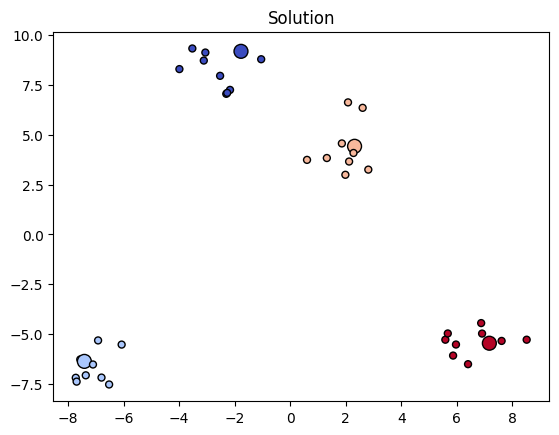

In [11]:
# centers are enlarged
plt.title("Solution")
sizes = [100 if tuple(point) in map(tuple, final_centers) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=sizes, edgecolor="k", cmap="coolwarm")
plt.show()

## Modified constraints for up to k centers

This is supposed to be an experiment to see if it changes anything. The hypothesis is that it shouldn't, as even if the optimal solution is just one big cluster, the extra centers can be used for the most distant points as centers with radius 0 that add nothing to the cost but reduce the radius of the big cluster.

In [12]:
mm = gp.Model("modified_kmsr")
# variable
my = mm.addVars(len(points), len(points), vtype=GRB.BINARY, name="Y")
# objective:
mm.setObjective(gp.quicksum([my[i, j] * radii[i][j] for i in range(len(radii)) for j in range(len(radii[i]))]),  GRB.MINIMIZE) 
# constraints:

# every point is covered by atleast one center/radius y_ij
for n in range(len(points)):
        mm.addConstr(gp.quicksum([my[i, j] for j in range(len(radii)) for i in range (len(radii)) if radii[i][j] >= dist.euclidean(points[n], points[i])]) >= 1, "every_point_covered")
# up to k centers open in total (not per row of y, so we don't get the sum of 10 different solutions)
mm.addConstr(gp.quicksum([my[i, j] for i in range (len(radii)) for j in range(len(radii[i]))]) <= k, "select_up_to_k_centers")
# this means we need a constraint that the number of centers can't be 0
mm.addConstr(gp.quicksum([my[i, j] for i in range (len(radii)) for j in range(len(radii[i]))]) >= 1, "select_more_than_0_centers")
# do the thing
mm.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 5800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 42 rows, 1600 columns and 36000 nonzeros
Model fingerprint: 0x510ea16e
Variable types: 0 continuous, 1600 integer (1600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 58.2597490
Presolve added 157 rows and 0 columns
Presolve removed 0 rows and 666 columns
Presolve time: 0.02s
Presolved: 199 rows, 934 columns, 9066 nonzeros
Found heuristic solution: objective 18.6481170
Variable types: 0 continuous, 934 integer (777 binary)

Root relaxation: objective 1.049930e+01, 149 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds     

In [13]:
final_centers = [points[i] for i in range(len(points)) for j in range(len(points)) if my[i, j].x == 1]
final_radii = [radii[i][j] for i in range(len(radii)) for j in range(len(radii[i])) if my[i, j].x == 1]

print("Optimal centers:")
for i in range(len(final_centers)): 
    print(f"Center {i} at point {final_centers[i]} with radius {final_radii[i]}")

Optimal centers:
Center 0 at point [ 2.31842051  4.42250683 -9.58319666  9.16360991] with radius 2.2872925756321396
Center 1 at point [ 7.17079438 -5.45623311 -6.11300781 -5.98546159] with radius 2.3147588238723977
Center 2 at point [-7.40938739 -6.36684216 -8.74125021  8.29216791] with radius 3.1272144882973163
Center 3 at point [-1.77073104  9.18565441  4.52423055  1.67206599] with radius 2.770035038512647


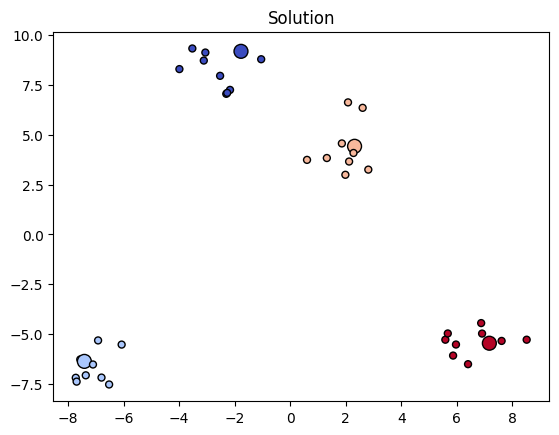

In [14]:
# centers are enlarged
plt.title("Solution")
sizes = [100 if tuple(point) in map(tuple, final_centers) else 25 for point in points]
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=sizes, edgecolor="k", cmap="coolwarm")
plt.show()